In [25]:
import io

import torch
import pyro
import pyro.distributions as dist
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

%matplotlib inline
sns.set_style("darkgrid")

In [2]:
new_data = """
x n y
0.28 45198 45183
0.97 183020 182899
1.93 169503 168594
2.92 113094 108953
3.93 73855 64740
4.94 53659 41106
5.94 42991 28205
6.95 37050 21334
7.95 33275 16615
8.95 30836 13503
9.95 28637 11060
10.95 26239 9032
11.95 24636 7687
12.95 22876 6432
14.43 41267 9813
16.43 35712 7196
18.44 31573 5290
20.44 28280 4086
21.95 13238 1642
24.39 46570 4767
28.40 38422 2980
32.39 31641 1996
36.39 25604 1327
40.37 20366 834
44.38 15977 559
48.37 11770 311
52.36 8708 231
57.25 8878 204
63.23 5492 103
69.18 3087 35
75.19 1742 24
"""

In [3]:
data = pd.read_csv(io.StringIO(new_data),sep=' ')
data['pct'] = data['y']/data['n']
data.head()

,x,n,y,pct
0,0.28,45198,45183,0.999668
1,0.97,183020,182899,0.999339
2,1.93,169503,168594,0.994637
3,2.92,113094,108953,0.963384
4,3.93,73855,64740,0.876582


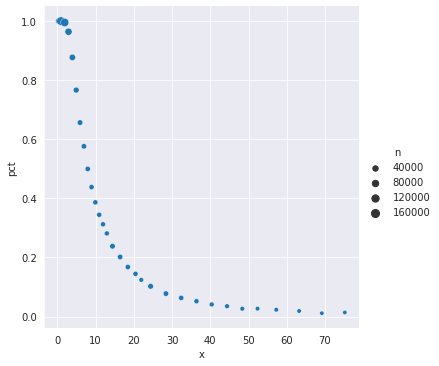

In [4]:
sns.relplot(data=data, x="x", y="pct", size="n")

In [167]:
def model(data):
    r = torch.tensor(1.68/24) # using torch.Tensor() here results in: TypeError: new(): data must be a sequence (got float)
    R = torch.tensor(4.25/24) 
    sigma = pyro.sample("sigma", dist.Uniform(0,1))
    x = torch.Tensor(data["x"])
    y = torch.Tensor(data["y"])
    n = torch.Tensor(data["n"])
    threshold_angle = torch.Tensor(np.arcsin((R-r) / x))
    p = torch.Tensor(2.0*dist.Normal(0,1).cdf(threshold_angle / sigma) - 1.0)
    with pyro.plate("data", len(data)):
        pyro.sample("succ", dist.Binomial(n, p), obs=y)
        return p

In [168]:
from pyro.infer.autoguide import AutoDiagonalNormal
guide = AutoDiagonalNormal(model)

In [169]:
from pyro.infer import SVI, Trace_ELBO

adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

In [170]:
pyro.clear_param_store()
for j in range(5000):
    # calculate the loss and take a gradient step
    loss = svi.step(data)
    if j % 500 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

[iteration 0001] loss: 58507.2505
[iteration 0501] loss: 335.4366
[iteration 1001] loss: 336.0773
[iteration 1501] loss: 334.6822
[iteration 2001] loss: 335.8616
[iteration 2501] loss: 334.5386
[iteration 3001] loss: 336.9940
[iteration 3501] loss: 334.4317
[iteration 4001] loss: 334.4262
[iteration 4501] loss: 334.3398


In [172]:
from pyro.infer import Predictive

def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats


predictive = Predictive(model, guide=guide, num_samples=800, return_sites=("succ","sigma","_RETURN"))
samples = predictive(data)
pred_summary = summary(samples)

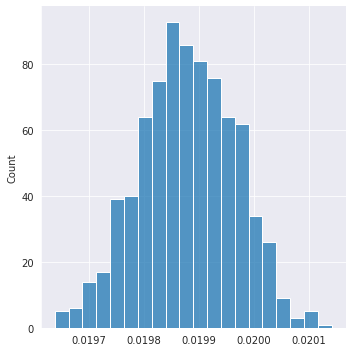

In [155]:
sigma = samples['sigma'].numpy().squeeze()
sns.displot(x=sigma, kind='hist')

In [177]:
data['pct_fit'] = pred_summary['_RETURN']['mean']
data['lo'] = pred_summary['_RETURN']['5%']
data['hi'] = pred_summary['_RETURN']['95%']

In [178]:
data.head(10)

,x,n,y,pct,pct_fit,lo,hi
0,0.28,45198,45183,0.999668,1.000000,1.000000,1.000000
1,0.97,183020,182899,0.999339,1.000000,1.000000,1.000000
2,1.93,169503,168594,0.994637,0.994772,0.994448,0.995075
3,2.92,113094,108953,0.963384,0.935013,0.933108,0.936834
4,3.93,73855,64740,0.876582,0.829620,0.826595,0.832529
5,4.94,53659,41106,0.766060,0.724567,0.721175,0.727841
6,5.94,42991,28205,0.656068,0.635598,0.632211,0.638871
7,6.95,37050,21334,0.575816,0.561772,0.558540,0.564899
8,7.95,33275,16615,0.499324,0.502023,0.498991,0.504957
9,8.95,30836,13503,0.437897,0.452796,0.449969,0.455532


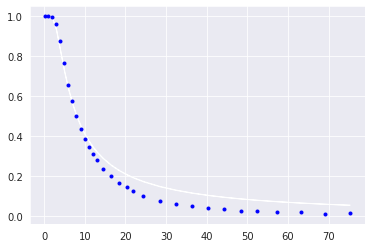

In [179]:
fig, ax = plt.subplots()
ax.plot(data['x'],data['pct'], 'b.')
ax.fill_between(data['x'], data['lo'], data['hi'])